# Realtime flow forecast with ECCC weather forecasts

This notebook shows how to perform a streamflow forecast, using ECCC weather forecasts. Generates the forecasts and plots them.

In [1]:
%matplotlib inline
# This entire section is cookie-cutter template to allow calling the servers and instantiating the connection
# to the WPS server. Do not modify this block.
from urllib.request import urlretrieve
from birdy import WPSClient
from ravenpy.utilities.testdata import get_file
from pathlib import Path
import json
import os
import datetime as dt
import tempfile
import xarray as xr

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get(
    "WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
)
wps = WPSClient(url)
tmp = Path(tempfile.mkdtemp())

In [2]:
# Define some of the catchment properties. Could also be replaced by a call to the properties WPS!
region_vector = str(get_file("watershed_vector/LSJ_LL.zip"))

basin_area = 44523.5
basin_longitude = -72.55
basin_latitude = 48.39
basin_elevation = 300.0

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE' and 'HBVEC'.
hydromodel = "GR4JCN"

# Since we've used GR4JCN, we need to provide that model's parameters.
gr4j_parameters = "0.529, -3.396, 407.29, 1.072, 16.9, 0.947"

nc_transforms = json.dumps(
    {"tas": {"time_shift": -0.25}, "pr": {"time_shift": -0.25, "deaccumulate": True}}
)

# Length of the desired forecast, in days
duration = 7

# launch the hydrological realtime forecasting WPS
resp_fcst = wps.realtime_forecast(
    region_vector=region_vector,
    latitude=basin_latitude,
    longitude=basin_longitude,
    area=basin_area,
    elevation=basin_elevation,
    forecast_model="GEPS",
    gr4jcn=gr4j_parameters,
    duration=duration,
    rvc=str(get_file("gr4j_cemaneige/solution.rvc")),
    nc_spec=nc_transforms,
    rain_snow_fraction="RAINSNOW_DINGMAN",
)

In [3]:
# The model has run! We can get the response.
# With `asobj` set to False, only the reference to the output is returned in the response.
# Setting `asobj` to True will retrieve the actual files and copy them locally.
[hydrograph_url, storage_url, solution_url, diagnostics_url, rv_url] = resp_fcst.get()

### And, for visual representation of the forecasts:

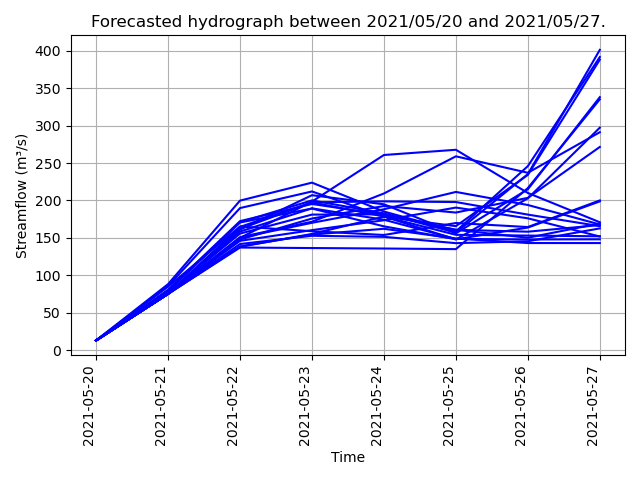

In [4]:
wps.graph_forecast_uncertainty(fcst=hydrograph_url).get(asobj=True)[0]